# Predicting the wave height and period for NDBC buoys
This project focuses on developing predictive models for wave height and wave period using real-time buoy data from the National Data Buoy Center (NDBC). The goal is to design an efficient and accurate forecasting system that leverages environmental and oceanographic variables, such as wind speed, wind direction, water temperature, and atmospheric pressure.

This system could be valuable for offshore energy projects, marine navigation safety, and coastal monitoring systems by providing faster, more reliable wave condition forecasts.

In [ ]:
# import libraries needed
from seebuoy import NDBC
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [67]:
"""
    Imports data from the National Data Buoy Center (NOAA)
    @param buoy_num: the buoy number of the closest x,y coordinates
    @return see_buoy: the buoy data in a dataframe
"""
ndbc = NDBC()

# Information on NDBC's ~1800 buoys and gliders
wave_df = ndbc.stations()

# list all available data for all buoys
df_data = ndbc.available_data()

# Get info on a single buoy
buoy = ndbc.get_data("44097") #BOSTON BUOY 44097
buoy = buoy.reset_index()
buoy

,date,wind_direction,wind_speed,wind_gust,wave_height,dominant_period,average_period,mean_wave_direction,pressure,air_temp,water_temp,dewpoint,visibility,pressure_tendency,tide
0,2025-03-16 00:26:00,NaN,NaN,NaN,1.1,13,6.1,114.0,NaN,NaN,5.6,NaN,NaN,NaN,NaN
1,2025-03-16 00:56:00,NaN,NaN,NaN,1.1,13,6.0,120.0,NaN,NaN,5.6,NaN,NaN,NaN,NaN
2,2025-03-16 01:26:00,NaN,NaN,NaN,1.1,11,6.2,113.0,NaN,NaN,5.6,NaN,NaN,NaN,NaN
3,2025-03-16 01:56:00,NaN,NaN,NaN,1.1,12,5.9,115.0,NaN,NaN,5.6,NaN,NaN,NaN,NaN
4,2025-03-16 02:26:00,NaN,NaN,NaN,1.0,13,5.6,114.0,NaN,NaN,5.6,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2158,2025-04-30 04:56:00,NaN,NaN,NaN,2.3,7,5.3,231.0,NaN,NaN,8.9,NaN,NaN,NaN,NaN
2159,2025-04-30 05:26:00,NaN,NaN,NaN,2.4,7,5.4,234.0,NaN,NaN,8.9,NaN,NaN,NaN,NaN
2160,2025-04-30 05:56:00,NaN,NaN,NaN,2.5,7,5.6,229.0,NaN,NaN,8.9,NaN,NaN,NaN,NaN
2161,2025-04-30 06:26:00,NaN,NaN,NaN,2.6,7,5.8,231.0,NaN,NaN,8.9,NaN,NaN,NaN,NaN


In [68]:
#### handler for missing data

def handle_missing_data(buoy):
    """
    The data has some missing values. We impute these values with interpolation.

    @param buoy: the data imported from Seebuoy
    @return buoy_interpolated: a dataframe of buoy data where we impute the missing values
    with interpolation
    """
    # missing data
    # total = buoy.isnull().sum().sort_values(ascending=False)
    # percent = (buoy.isnull().sum() / buoy.isnull().count()).sort_values(
    #     ascending=False
    # )
    # missing_data = pd.concat([total, percent], axis=1, keys=["Total", "Percent"])
    # missing_data
    
    # dropping rows where average_period is null
    buoy.dropna(subset=['average_period'], inplace=True)

    # dropping rows wehre wave_height is null
    buoy.dropna(subset=['wave_height'], inplace=True)

    # dropping cols where there is 100% NA
    buoy.dropna(axis=1, how='all', inplace=True)

    # IMPUTATIONS

    columns_to_fill = [
        "wind_direction",
        "wind_speed",
        "wind_gust",
        "dominant_period",
        "mean_wave_direction",
        "pressure",
        "air_temp",
        "water_temp",
        "dewpoint",
        "visibility",
        "pressure_tendency",
        "tide"
    ]


    # Interpolate missing values using spline interpolation
    buoy_interpolated = buoy.copy()
    for column in columns_to_fill:
        if column in buoy_interpolated:
            buoy_interpolated[column] = buoy_interpolated[column].fillna(buoy_interpolated[column].interpolate(method='spline', order=2))
    
    # check if there are any additional missing values
    for column in columns_to_fill:
        if column in buoy_interpolated.columns and buoy_interpolated[column].isnull().any():
            buoy_interpolated = buoy_interpolated.drop(column, axis=1)

    return buoy_interpolated

### Handling Missing Data

In [69]:
total = buoy.isnull().sum().sort_values(ascending=False)
percent = (buoy.isnull().sum() / buoy.isnull().count()).sort_values(
    ascending=False
)
missing_data = pd.concat([total, percent], axis=1, keys=["Total", "Percent"])
#missing_data


In [70]:
# dropping rows where average_period is null
buoy.dropna(subset=['average_period'], inplace=True)

# dropping rows wehre wave_height is null
buoy.dropna(subset=['wave_height'], inplace=True)

# dropping cols where there is 100% NA
buoy.dropna(axis=1, how='all', inplace=True)
#buoy


In [71]:
columns_to_fill = [
    "wind_direction",
    "wind_speed",
    "wind_gust",
    "dominant_period",
    "mean_wave_direction",
    "pressure",
    "air_temp",
    "water_temp",
    "dewpoint",
    "visibility",
    "pressure_tendency",
    "tide"
]

# Interpolate missing values using spline interpolation
buoy_interpolated = buoy.copy()
for column in columns_to_fill:
    if column in buoy_interpolated:
        buoy_interpolated[column] = buoy_interpolated[column].fillna(buoy_interpolated[column].interpolate(method='spline', order=2))

# check if there are any additional missing values
for column in columns_to_fill:

    # makes sure that interpolated values are valid (not NaN)
    if column in buoy_interpolated.columns and buoy_interpolated[column].isnull().any():
        buoy_interpolated = buoy_interpolated.drop(column, axis=1)

buoy_interpolated


,date,wave_height,dominant_period,average_period,mean_wave_direction,water_temp
0,2025-03-16 00:26:00,1.1,13,6.1,114.0,5.6
1,2025-03-16 00:56:00,1.1,13,6.0,120.0,5.6
2,2025-03-16 01:26:00,1.1,11,6.2,113.0,5.6
3,2025-03-16 01:56:00,1.1,12,5.9,115.0,5.6
4,2025-03-16 02:26:00,1.0,13,5.6,114.0,5.6
...,...,...,...,...,...,...
2158,2025-04-30 04:56:00,2.3,7,5.3,231.0,8.9
2159,2025-04-30 05:26:00,2.4,7,5.4,234.0,8.9
2160,2025-04-30 05:56:00,2.5,7,5.6,229.0,8.9
2161,2025-04-30 06:26:00,2.6,7,5.8,231.0,8.9


In [72]:
def visualize_column_interpolation(original_df, interpolated_df, column_name, datetime_column='date'):
    """
    Plots original vs interpolated values for a specific column with datetime on the x-axis.
    """
    plt.figure(figsize=(14,6))

    # Plot original data
    plt.plot(original_df[datetime_column], original_df[column_name], 
             label='Original', linestyle='--', marker='o', alpha=0.5)
    
    # Plot interpolated data
    plt.plot(interpolated_df[datetime_column], interpolated_df[column_name], 
             label='Interpolated', linestyle='-', marker='.', alpha=0.8)

    plt.title(f'Visualization of {column_name}: Original vs Interpolated')
    plt.xlabel('Datetime')
    plt.ylabel(column_name)
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)  # rotate dates so they fit better
    plt.tight_layout()
    plt.show()

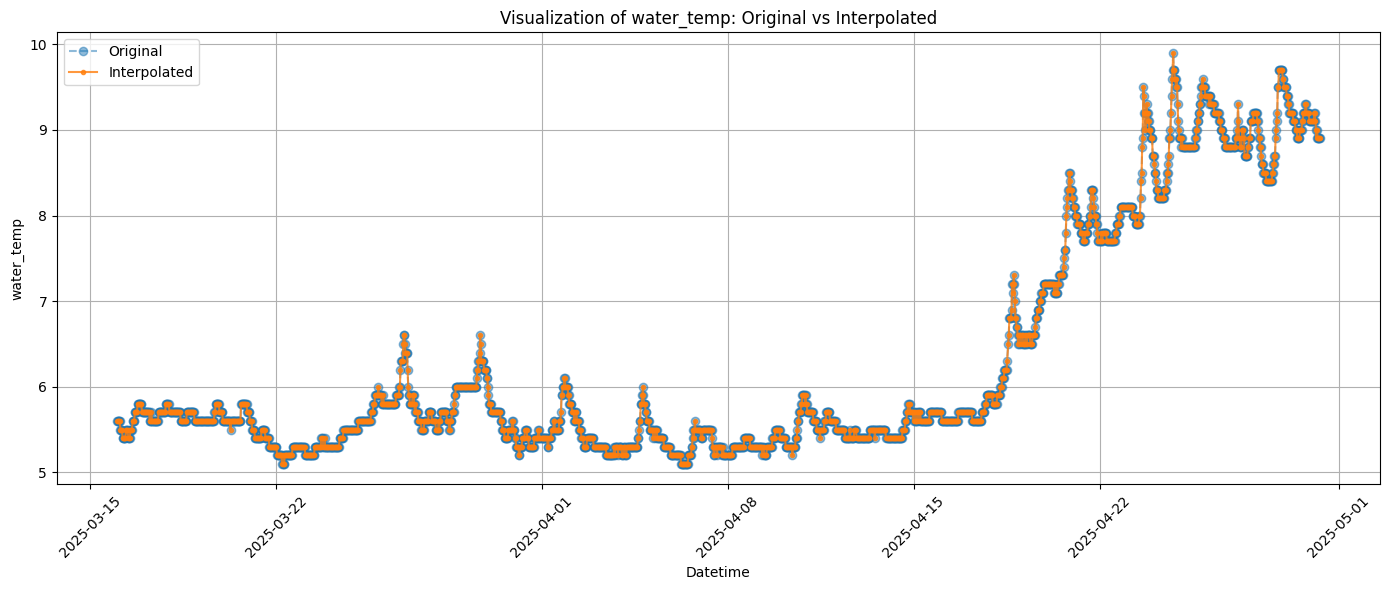

In [73]:
# Example: visualize wind_speed
visualize_column_interpolation(buoy, buoy_interpolated, 'water_temp')

# You can do this for any column you care about
# visualize_column_interpolation(buoy, buoy_interpolated, 'air_temp')
# visualize_column_interpolation(buoy, buoy_interpolated, 'pressure')

In [83]:
buoy_cleaned = handle_missing_data(buoy)

### Feature Engineering: Resampling and data lagging


- defining the month vairables
- creating new columns for lag
- lagging the target variable!

In [84]:
buoy_cleaned['date'] = pd.to_datetime(buoy_cleaned['date'])

# Set the 'date' column as the index
buoy_cleaned.set_index('date', inplace=True)

daily_df = buoy_cleaned.resample('D').mean()

daily_df['month'] = daily_df.index.month

In [85]:
for lag in range(1, 4):  # create 7 days' worth of lag features
    daily_df[f'wave_height_lag{lag}'] = daily_df['wave_height'].shift(lag)
    daily_df[f'water_temp_lag{lag}'] = daily_df['water_temp'].shift(lag)

In [86]:
# daily_df

### Exploratory Data Analysis

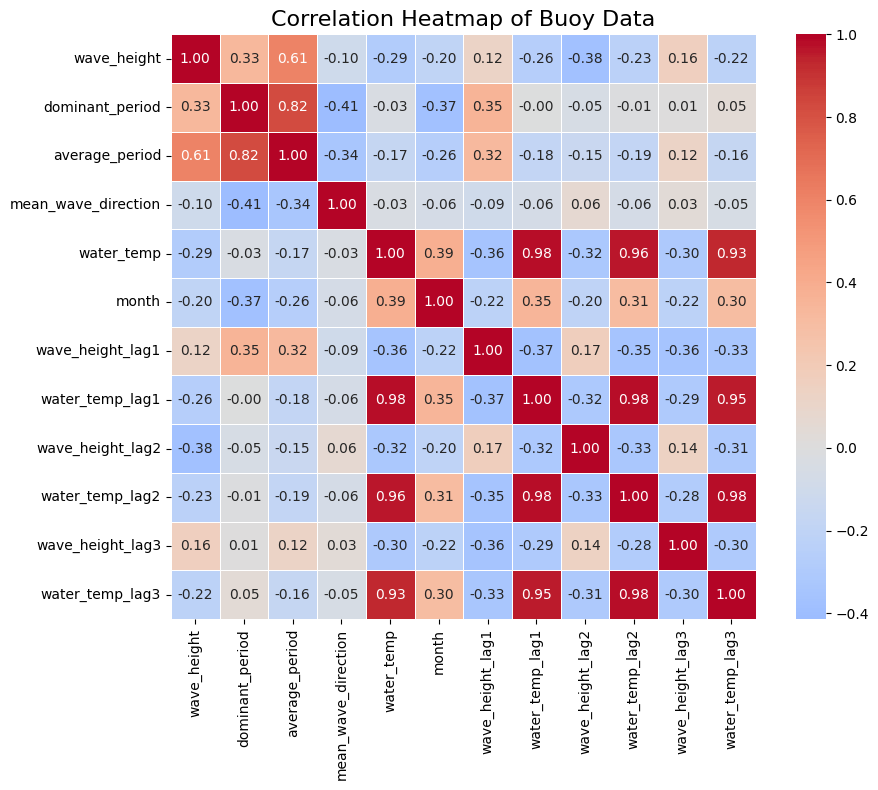

In [87]:
# Compute correlation matrix for buoy_cleaned
corr_matrix = daily_df.corr(numeric_only=True)

# Compute correlation matrix
corr_matrix = daily_df.corr(numeric_only=True)

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap
sns.heatmap(
    corr_matrix,
    annot=True,         # show correlation values
    fmt=".2f",          # format to 2 decimal places
    cmap="coolwarm",    # color map: blue (negative) to red (positive)
    center=0,           # center the colormap at zero
    square=True,        # square cells
    linewidths=.5       # lines between cells
)

# Add title
plt.title('Correlation Heatmap of Buoy Data', fontsize=16)

# Show plot
plt.tight_layout()
plt.show()


### Prediction Target: Wave Height

makes sure that the future wave height of plus 5 days is NaN. This is what we are trying to predict

In [88]:
daily_df['wave_height_t+5'] = daily_df['wave_height'].shift(-5)

### Train test split

In [98]:
model_df = daily_df.dropna()

train = model_df.iloc[:-10]
test = model_df.iloc[-10:]

In [99]:
model_df['naive_pred'] = model_df['wave_height'].shift(5)

C:\Users\maris\AppData\Local\Temp\ipykernel_26672\1284444002.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df['naive_pred'] = model_df['wave_height'].shift(5)


### Naive Baseline

The wave height will be the same as it was 5 days ago

In [100]:
# Drop NaNs created by shift
baseline_df = model_df.dropna(subset=['wave_height_t+5', 'naive_pred'])
model_df['naive_pred'] = model_df['wave_height'].shift(5)

# Re-split the data now that we’ve added a new column
train = model_df.iloc[:-10]
test = model_df.iloc[-10:]

# Extract the naive predictions from the test set
naive_preds = test['naive_pred']
mae_naive = mean_absolute_error(baseline_df['wave_height_t+5'], baseline_df['naive_pred'])
print(f"Naive Baseline MAE: {mae_naive:.3f}")

Naive Baseline MAE: 0.476


C:\Users\maris\AppData\Local\Temp\ipykernel_26672\2913349532.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df['naive_pred'] = model_df['wave_height'].shift(5)


### Random Forest

In [101]:
features = [col for col in train.columns if not col.startswith('wave_height_t+')]
X_train = train[features]
y_train = train['wave_height_t+5']
X_test = test[features]
y_test = test['wave_height_t+5']

model = RandomForestRegressor()
model.fit(X_train, y_train)

preds = model.predict(X_test)

### Evaluating

In [102]:
# Compare predictions to actual values
mae = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))

print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")

MAE: 0.644
RMSE: 0.717


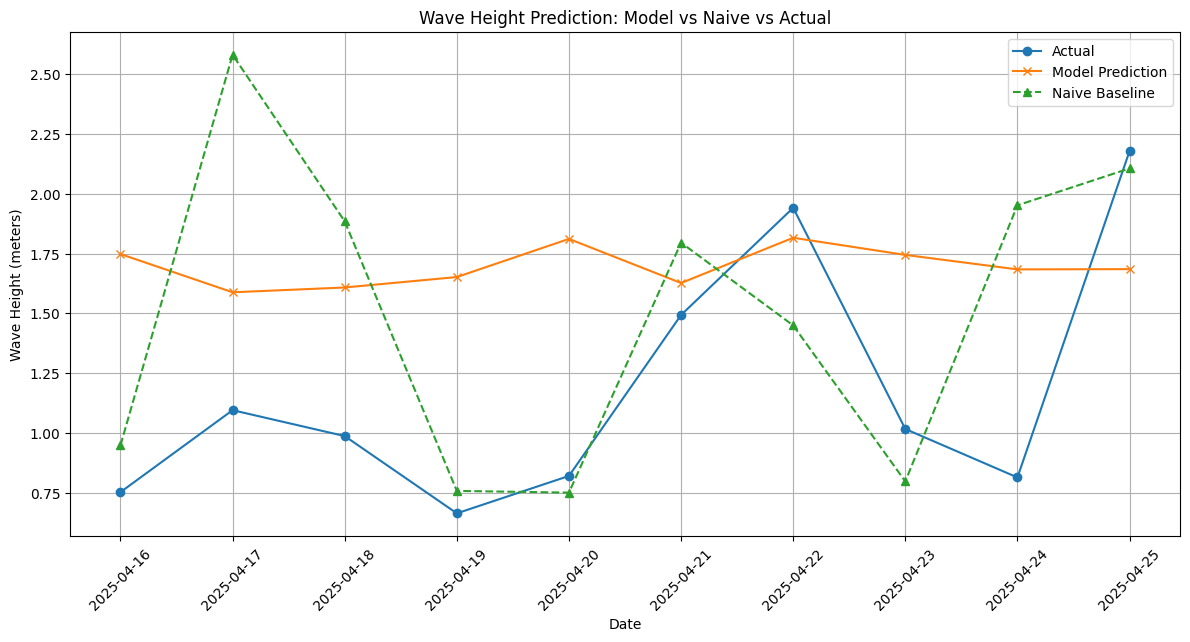

In [103]:
# Plot actual vs model vs naive
plt.figure(figsize=(12, 6))

# Actual future wave heights
plt.plot(test.index, y_test, label='Actual', marker='o')

# Your model's predictions
plt.plot(test.index, preds, label='Model Prediction', marker='x')

# Naive baseline predictions
plt.plot(test.index, naive_preds, label='Naive Baseline', linestyle='--', marker='^')

# Chart settings
plt.xlabel('Date')
plt.ylabel('Wave Height (meters)')
plt.title('Wave Height Prediction: Model vs Naive vs Actual')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


### Facebook's Prophet

In [113]:
from prophet import Prophet

# Prepare the training DataFrame for Prophet
prophet_df = model_df.reset_index()[['date', 'wave_height_t+5']].copy()
prophet_df = prophet_df.rename(columns={'date': 'ds', 'wave_height_t+5': 'y'})

# Interpolate missing y values (optional, if needed)
prophet_df['y'] = prophet_df['y'].interpolate()

# Optional: logistic cap (not strictly needed unless you're using logistic growth)
cap = prophet_df['y'].max() + 1
prophet_df['cap'] = cap



In [114]:
from prophet import Prophet

model = Prophet(growth='logistic', daily_seasonality=True)
model.fit(prophet_df)


01:16:47 - cmdstanpy - INFO - Chain [1] start processing
01:16:47 - cmdstanpy - INFO - Chain [1] done processing


In [115]:
# Only forecast dates that exist in the test set
future = pd.DataFrame({'ds': test.index})
future['cap'] = cap  # required if using logistic growth

forecast = model.predict(future)

# Get the predictions
prophet_preds = forecast['yhat'].values


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae_prophet = mean_absolute_error(y_test, prophet_preds)
rmse_prophet = np.sqrt(mean_squared_error(y_test, prophet_preds))

print(f"Prophet MAE: {mae_prophet:.3f}")
print(f"Prophet RMSE: {rmse_prophet:.3f}")


📈 Prophet MAE: 0.305
📈 Prophet RMSE: 0.374


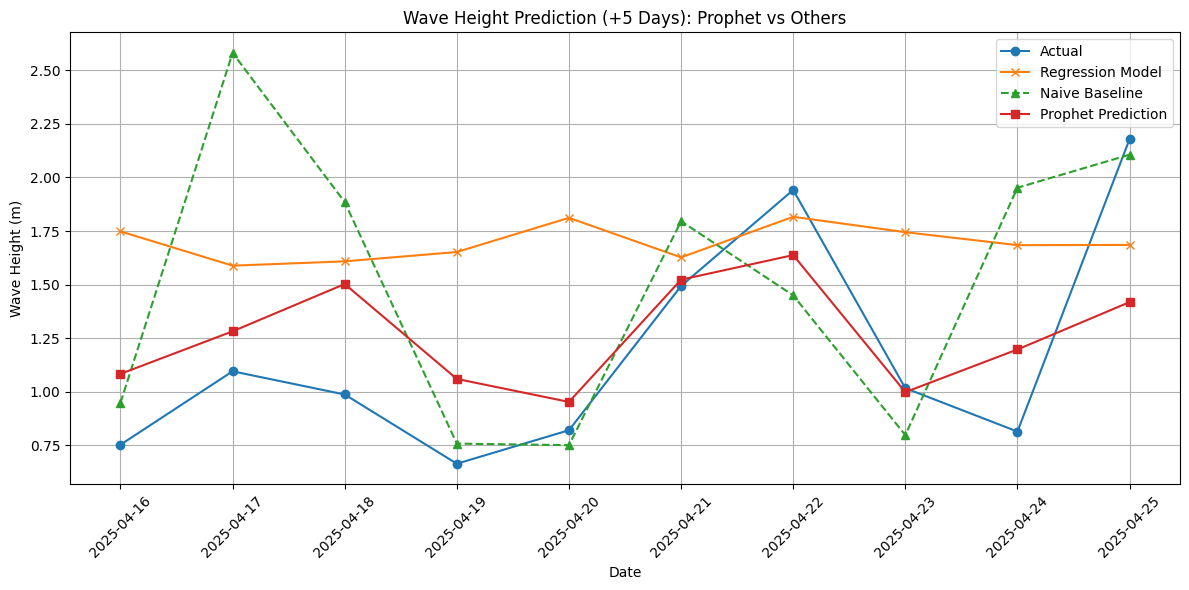

In [117]:
plt.figure(figsize=(12, 6))

plt.plot(test.index, y_test, label='Actual', marker='o')
plt.plot(test.index, preds, label='Regression Model', marker='x')
plt.plot(test.index, test['naive_pred'], label='Naive Baseline', linestyle='--', marker='^')
plt.plot(test.index, prophet_preds, label='Prophet Prediction', linestyle='-', marker='s')

plt.title("Wave Height Prediction (+5 Days): Prophet vs Others")
plt.xlabel("Date")
plt.ylabel("Wave Height (m)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Linear Regression

In [121]:
train

,wave_height,dominant_period,average_period,mean_wave_direction,water_temp,month,wave_height_lag1,water_temp_lag1,wave_height_lag2,water_temp_lag2,wave_height_lag3,water_temp_lag3,wave_height_t+5,naive_pred
date,,,,,,,,,,,,,,
2025-03-19,1.387500,10.145833,6.025000,135.645833,5.645833,3,2.406250,5.668750,2.663830,5.680851,1.175000,5.583333,1.495833,NaN
2025-03-20,1.406250,10.770833,7.037500,129.000000,5.654167,3,1.387500,5.645833,2.406250,5.668750,2.663830,5.680851,2.043750,NaN
2025-03-21,1.845833,8.854167,5.831250,185.708333,5.414583,3,1.406250,5.654167,1.387500,5.645833,2.406250,5.668750,1.375000,NaN
2025-03-22,1.402083,6.708333,4.683333,219.166667,5.233333,3,1.845833,5.414583,1.406250,5.654167,1.387500,5.645833,1.487500,NaN
2025-03-23,1.775000,6.666667,4.883333,231.687500,5.272917,3,1.402083,5.233333,1.845833,5.414583,1.406250,5.654167,1.312500,NaN
2025-03-24,1.495833,6.854167,4.787500,176.145833,5.410417,3,1.775000,5.272917,1.402083,5.233333,1.845833,5.414583,1.266667,1.387500
2025-03-25,2.043750,9.020833,6.791667,166.729167,5.697917,3,1.495833,5.410417,1.775000,5.272917,1.402083,5.233333,1.547917,1.406250
2025-03-26,1.375000,8.562500,6.427083,164.291667,6.000000,3,2.043750,5.697917,1.495833,5.410417,1.775000,5.272917,1.593617,1.845833
2025-03-27,1.487500,5.625000,4.447917,255.187500,5.666667,3,1.375000,6.000000,2.043750,5.697917,1.495833,5.410417,1.989583,1.402083


In [122]:
from sklearn.linear_model import LinearRegression

# Use same features as other models (excluding the target)
features = [col for col in train.columns if not col.startswith('wave_height_t+') and col != 'naive_pred']

# Inputs and target
X_train = train[features]
y_train = train['wave_height_t+5']
X_test = test[features]
y_test = test['wave_height_t+5']

# Train Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
lr_preds = lr_model.predict(X_test)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae_lr = mean_absolute_error(y_test, lr_preds)
rmse_lr = np.sqrt(mean_squared_error(y_test, lr_preds))

print(f"Linear Regression MAE: {mae_lr:.3f}")
print(f"Linear Regression RMSE: {rmse_lr:.3f}")


📉 Linear Regression MAE: 2.027
📉 Linear Regression RMSE: 2.240


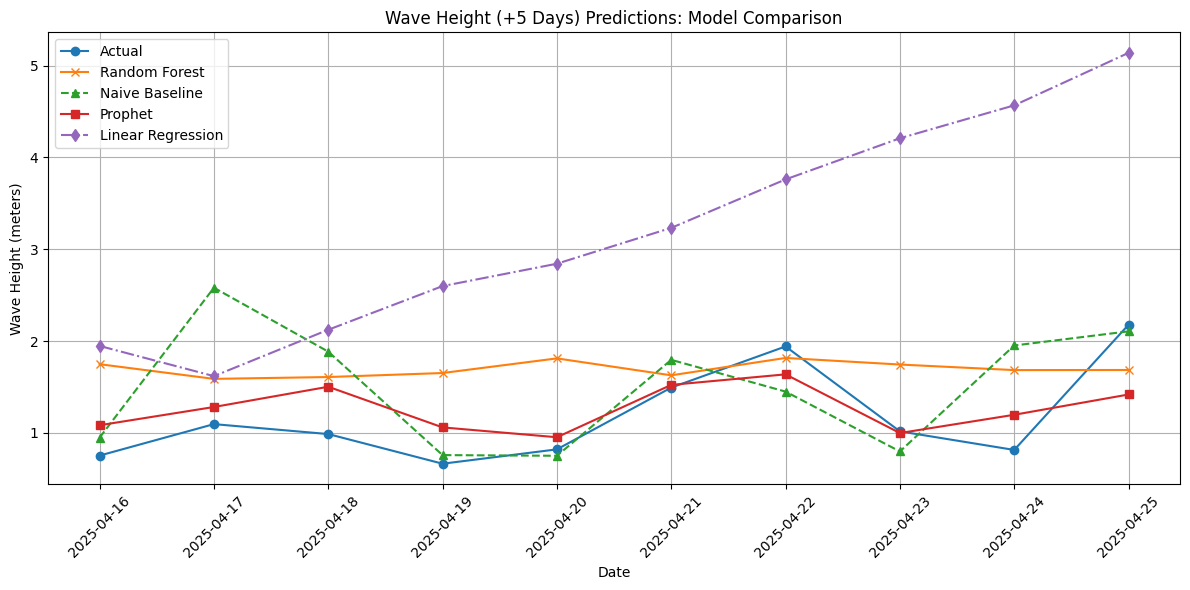

In [124]:
plt.figure(figsize=(12, 6))

# Actual wave heights (targets)
plt.plot(test.index, y_test, label='Actual', marker='o')

# Predictions from different models
plt.plot(test.index, preds, label='Random Forest', marker='x')
plt.plot(test.index, test['naive_pred'], label='Naive Baseline', linestyle='--', marker='^')
plt.plot(test.index, prophet_preds, label='Prophet', linestyle='-', marker='s')
plt.plot(test.index, lr_preds, label='Linear Regression', linestyle='-.', marker='d')

plt.title("Wave Height (+5 Days) Predictions: Model Comparison")
plt.xlabel("Date")
plt.ylabel("Wave Height (meters)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
